In [ ]:
#%pip install --upgrade tensorflow

In [ ]:
%pip install tensorflow
%pip install tf_slim
%pip install tensorflow-hub
%pip install tensorflow-object-detection-api
%pip install tf-models-official
%pip install opencv-python
#%pip install object_detection
#%pip install utils
%pip install protobuf-compiler
%pip install protobuf


In [1]:
#QUESTO
import os
import numpy as np
import tensorflow as tf
from object_detection.utils import ops as utils_ops
from object_detection.utils import visualization_utils as vis_util
from PIL import Image
import pathlib

def load_model(model_name):
    base_url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(
      fname=model_name, 
      origin=base_url + model_file,
      untar=True)

    model_dir = pathlib.Path(model_dir)/"saved_model"
    model = tf.saved_model.load(str(model_dir))
    return model

def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]

    # Run inference
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                  for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)   

    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                  output_dict['detection_masks'], output_dict['detection_boxes'],
                   image.shape[0], image.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                           tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()  
    
    return output_dict

def show_inference(model, image_path, category_index):
# Load image using PIL
    image = Image.open(image_path)
    image_np = np.array(image, dtype=np.uint8)
    
    # Actual detection.
    output_dict = run_inference_for_single_image(model, image_np)
    
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=5)

    return image_np

def read_label_map(label_map_path):
    category_index = {}
    with open(label_map_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            if line.startswith('name:'):
                name = line[len('name:'):].strip().strip('\'"')
            elif line.startswith('id:'):
                class_id = int(line[len('id:'):])
                category_index[class_id] = {'id': class_id, 'name': name}
                
    return category_index

Il file esiste nel percorso specificato.
Categoria ID: 1, Nome: {'id': 1, 'name': '/m/01g317'}
Categoria ID: 2, Nome: {'id': 2, 'name': '/m/0199g'}
Categoria ID: 3, Nome: {'id': 3, 'name': '/m/0k4j'}
Categoria ID: 4, Nome: {'id': 4, 'name': '/m/04_sv'}
Categoria ID: 5, Nome: {'id': 5, 'name': '/m/05czz6l'}
Categoria ID: 6, Nome: {'id': 6, 'name': '/m/01bjv'}
Categoria ID: 7, Nome: {'id': 7, 'name': '/m/07jdr'}
Categoria ID: 8, Nome: {'id': 8, 'name': '/m/07r04'}
Categoria ID: 9, Nome: {'id': 9, 'name': '/m/019jd'}
Categoria ID: 10, Nome: {'id': 10, 'name': '/m/015qff'}
Categoria ID: 11, Nome: {'id': 11, 'name': '/m/01pns0'}
Categoria ID: 13, Nome: {'id': 13, 'name': '/m/02pv19'}
Categoria ID: 14, Nome: {'id': 14, 'name': '/m/015qbp'}
Categoria ID: 15, Nome: {'id': 15, 'name': '/m/0cvnqh'}
Categoria ID: 16, Nome: {'id': 16, 'name': '/m/015p6'}
Categoria ID: 17, Nome: {'id': 17, 'name': '/m/01yrx'}
Categoria ID: 18, Nome: {'id': 18, 'name': '/m/0bt9lr'}
Categoria ID: 19, Nome: {'id': 19,

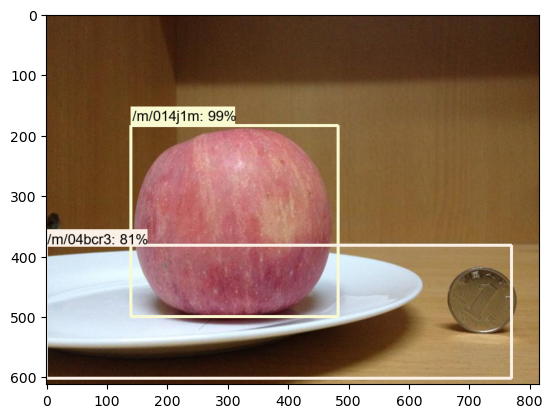

In [11]:
import os
import matplotlib.pyplot as plt

model_name = 'faster_rcnn_resnet101_v1_640x640_coco17_tpu-8'

def load_label_map(label_map_path):
    label_map_path = '..\\tf_models\\research\\object_detection\\data\\mscoco_label_map.pbtxt'
    category_index = None

    if os.path.isfile(label_map_path):

        print("Il file esiste nel percorso specificato.")
        with open(label_map_path, 'r') as f:
            label_map = f.read()

        category_index = read_label_map(label_map_path)
        for category_id, category_info in category_index.items():
            print(f"Categoria ID: {category_id}, Nome: {category_info}")
            
    else:
        print("Il file NON esiste nel percorso specificato.")

    return category_index

def run_inference_and_display_results(model, image_path, category_index):

    image_np = show_inference(model, image_path, category_index)

    #serve per far funzionare il plt
    %matplotlib inline 
    plt.imshow(image_np)
    plt.show()

def detect_objects_in_image(image_path):

    model = load_model(model_name)
    label_map_path = '..\\tf_models\\research\\object_detection\\data\\mscoco_label_map.pbtxt'
    category_index = load_label_map(label_map_path)
    run_inference_and_display_results(model, image_path, category_index)

image_path1 = '..\Dataset\JPEGImages\Apple\S_Apple\\apple002S(5).JPG'  
detect_objects_in_image(image_path1)



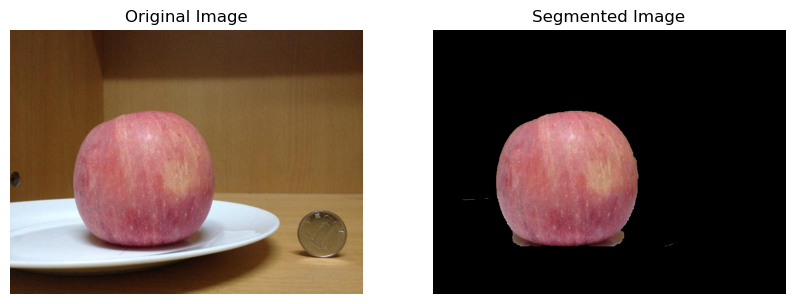

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def run_grabcut(image_path):
    # Load the image
    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    # Create a mask with zeros, same size as the image
    mask = np.zeros((height, width), np.uint8)

    # Create a rectangle around the region of interest (foreground)
    rect = (50, 50, width-300, height-160)
    # Initialize the GrabCut algorithm
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    # Run the GrabCut algorithm
    cv2.grabCut(image, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

    # Create a binary mask where the foreground is True (3 and 1 are the possible states of the mask)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    # Multiply the original image with the binary mask to get the segmented image
    segmented_image = image * mask2[:, :, np.newaxis]

    # Display the original image and the segmented image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Segmented Image')

    plt.show()

image_path = '..\Dataset\JPEGImages\Apple\S_Apple\\apple002S(5).JPG'  
run_grabcut(image_path)
